Instructor: Juber Rahman<br>
Dataset: St Petersburg INCART dataset from Physionet<br>
Signal: 12-lead ECG<br>
Pre-processing: neurokit<br>
Method: 1-D CNN or Multi-head CNN<br>
last updated: Nov 12, 2021<br>

**Prework-**<br/>
1.1: Watch a 12 lead ECG video https://www.youtube.com/watch?v=kwLbSx9BNbU <br/> 1.2: read the dataset description from Physionet and identify the heart diseases in the database <br/> 1.3: Which ECG channel data is the most informative for these diseases ? <br/> 1.4 How these diseases MI, CAD, TIA etc. differ from each other, what morphological changes are introduced in the ECG signal? <br/> 1.5 For classification purpose combine the categories with few records into one as 'other' category

### Step 0 - Install and import required libraries..

In [ ]:
#!pip install peakutils

In [1]:
import wfdb
from wfdb import processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import peakutils

### Step 1 - Download the entire dataset to local folders..

In [ ]:
# Download all the WFDB records and annotations from a small Physionet Database
# St Petersburg INCART 12-lead Arrhythmia Database
# 75 annotated recordings. Each record is 30 minutes long and contains 12 standard leads, each sampled at 257 Hz
# For each record, the .hea file includes the patient's age, sex, diagnoses, and a summary of features of the ECG. 
# Each .hea file also includes a patient number (1–32) that identifies the source recording

# Make a temporary download directory in your current working directory
cwd = os.getcwd()
dl_dir = os.path.join(cwd, 'incartdb')

# Download all the WFDB content
wfdb.dl_database('incartdb', dl_dir=dl_dir)

# Display the downloaded content in the folder
display(os.listdir(dl_dir))

# Cleanup: delete the downloaded directory
#shutil.rmtree(dl_dir)

### Step 2 - Explore Data record format - Let us read one record and see the output in terms of variables, formatting etc. This will help in feature extraction for each record..

In [2]:
record = wfdb.rdrecord('incartdb/I14')
annotation = wfdb.rdann('incartdb/I14', 'atr')

In [5]:
# Let us see how each record looks and the various variables it has
from pprint import pprint
pprint(vars(record))

{'adc_gain': [617.0,
              617.0,
              617.0,
              617.0,
              617.0,
              617.0,
              617.0,
              617.0,
              617.0,
              617.0,
              617.0,
              617.0],
 'adc_res': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
 'adc_zero': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'block_size': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'byte_offset': [None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 None],
 'checksum': [5050,
              -18798,
              32312,
              18427,
              15197,
              32133,
              -6981,
              13745,
              -13006,


In [6]:
#Let us check the ECG values in channel 0
record.p_signal[:,0]

array([3.99351702, 3.98703404, 3.98865478, ..., 2.11507293, 2.11831442,
       2.11831442])

In [7]:
#Let us also review how many annotations exist. They should approximately equal to the number of beats in the recording
annotation.ann_len

1866

In [8]:
# Let us check the various beat types in this record and their frequency
from collections import Counter
words = annotation.symbol
Counter(words).keys() # equals to list(set(words))

dict_keys(['N', 'V'])

In [9]:
Counter(words).values() # counts the elements ' frequency

dict_values([1802, 64])

In [10]:
# Let us now try to get the neurokit features for this record
import neurokit2 as nk

# Preprocess the data (filter, find peaks, etc.)
processed_data, info = nk.bio_process(ecg=record.p_signal[:,0], sampling_rate=257)

# Compute relevant features
results = nk.bio_analyze(processed_data, sampling_rate=257)

In [11]:
results

,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSE,HRV_CMSE,HRV_RCMSE,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,61.052486,984.800184,131.919782,59.922698,100.108737,48.981313,106.90872,34.81449,116.187453,102.079344,...,0.885219,6.547896,0.6396,0.922301,1.007478,0.99231,0.586954,1.93903,2.680593,0.646746


In [12]:
type(results) # result of neurokit is a pandas datadrame.

pandas.core.frame.DataFrame

In [13]:
# Now let us see how comments are organised and how we can extract structured information from comments

In [20]:
record.comments

['<age>: 39 <sex>: F', 'patient 6', 'PVCs, baseline wander']

In [14]:
record.comments[0]

'<age>: 39 <sex>: F'

In [17]:
# Let's get Age
record.comments[0].split("<age>: ",1)[1][0:2]

'39'

In [18]:
# Let's get Gender
record.comments[0].split("<sex>: ",1)[1][0:1]

'F'

In [21]:
record.comments[1]

'patient 6'

### Step 3 - Creating base input dataset

#### Now that we know format of each record, let us try to create feature row for each record

In [23]:
import neurokit2 as nk
from collections import Counter

### Define the function to generate feature record - 

In [24]:
def generate_feature_record(user):

    # Read the record
    record = wfdb.rdrecord('incartdb/'+user)
    annotation = wfdb.rdann('incartdb/'+user, 'atr')
    
    # Let us use bio_process function from Neurokit to preprocess the data (filter, find peaks, etc.)
    # We will use ECG Channel V5 which is at position 10 in the arrary
    processed_data, info = nk.bio_process(ecg=record.p_signal[:,10], sampling_rate=257)

    # Let us use bio_analyze funtion from Neurokit to compute relevant features
    results = nk.bio_analyze(processed_data, sampling_rate=257)
    
    # Adding additional information from comments to the feature record
    results['comment_0']=record.comments[0]
    results['comment_1']=record.comments[1]
    results['comment_2']=record.comments[2]
    
    # Parsing the first row from comments to get Age and Sex information -
    results['age']=record.comments[0].split("<age>: ",1)[1][0:2]
    results['sex']=record.comments[0].split("<sex>: ",1)[1][0:1]
    
    # Let us get the diagnosis from comment line. 
    # If the patient is healthy there is no diagnosis. Handling this condition - 
    try:
        results['diagnosis']=str(record.comments[0].split("<diagnoses> ",1)[1])
    except:
        results['diagnosis']='Healthy'

    results['Patient ID']=record.comments[1]

    results['record_name']=record.record_name
    results['sig_len']=record.sig_len
    
    # Calculating no_of_beats_expected = avg heart rate * 30 minutes
    results['no_of_beats_expected']=int(results['ECG_Rate_Mean']*30)
    
    # Adding informtation from annotations to the results
    results['annot_length'] = annotation.ann_len
    
    # Adding count of different beat classifications from annotations    
    beats = annotation.symbol
    print(Counter(beats).keys()) # equals to list(set(words))
    print(Counter(beats).values()) # counts the elements' frequency
    
    results['no_of_A_beats']=beats.count('A')    
    results['no_of_F_beats']=beats.count('F')    
    results['no_of_j_beats']=beats.count('j')    
    results['no_of_N_beats']=beats.count('N')
    results['no_of_n_beats']=beats.count('n')
    results['no_of_Q_beats']=beats.count('Q')    
    results['no_of_R_beats']=beats.count('R')
    results['no_of_S_beats']=beats.count('S')
    results['no_of_V_beats']=beats.count('V')
    results['no_of_+_beats']=beats.count('+')
    
    results['percentage_of_A_beats']=(beats.count('A')/annotation.ann_len)*100
    results['percentage_of_F_beats']=(beats.count('F')/annotation.ann_len)*100
    results['percentage_of_j_beats']=(beats.count('j')/annotation.ann_len)*100
    results['percentage_of_N_beats']=(beats.count('N')/annotation.ann_len)*100
    results['percentage_of_n_beats']=(beats.count('n')/annotation.ann_len)*100
    results['percentage_of_Q_beats']=(beats.count('Q')/annotation.ann_len)*100
    results['percentage_of_R_beats']=(beats.count('R')/annotation.ann_len)*100
    results['percentage_of_S_beats']=(beats.count('S')/annotation.ann_len)*100
    results['percentage_of_V_beats']=(beats.count('V')/annotation.ann_len)*100
    results['percentage_of_+_beats']=(beats.count('+')/annotation.ann_len)*100
    
    return(results)

In [25]:
# List of files that we do not want to process
problematic_files = [ # try to process these seperately
    '.DS_Store',
    'I19.dat',
    'I26.dat',
    'I43.dat',
    'I53.dat',
    'I51.dat'
]

### Looping for all files in the folders and calling function to generate feature record

In [26]:
#Indicator to write header row only once
write_header = True

In [ ]:
for filename in next(os.walk('incartdb'))[2]:
    # skip any file that may be problematic / we do not want to process
    if filename in problematic_files:
        print(filename, 'problematic file')
    else:
        # Skip the files that are not with .dat extension.
        # remember that there are 3 files per user and wfdb.rdrecord needs just the username
        if os.path.splitext(filename)[1] != '.dat':
            print(filename, 'file skipped')
        else:
            # call the function to process the user record and write results received as feature record to csv
            print(filename, 'generating feature record')
            results = generate_feature_record(os.path.splitext(filename)[0])
            # When writing to the feature csv file for first time, write the header row. 
            # Write only record without header during subsequent loops 
            if write_header == True:
                results.to_csv('features.csv', mode='w', index = False, header=True)
                write_header = False
            else:
                results.to_csv('features.csv', mode='a', index = False, header=False)           

### Step 4 - Feature engineering - 

In [28]:
# Read the feature file from previous step

In [1]:
import pandas as pd
df = pd.read_csv('features.csv')

In [2]:
# Split between Primary, Secondary, Tertiary diagnosis

In [3]:
df_diagnosis = df['diagnosis'].str.split(', ', expand=True)

In [4]:
df_diagnosis.columns=['diagnosis_primary', 'diagnosis_secondary','diagnosis_tertiary']

In [5]:
df = pd.concat([df, df_diagnosis], axis=1)

In [6]:
# Let us add binary distribution for diagnosis - Healthy = False, Diseased = True

In [7]:
df['diagnosis_binary']= (df['diagnosis']!='Healthy')

In [8]:
df['diagnosis_binary']

0      True
1      True
2      True
3      True
4     False
      ...  
65    False
66     True
67    False
68    False
69    False
Name: diagnosis_binary, Length: 70, dtype: bool

In [9]:
df['diagnosis']

0                          Transient ischemic attack
1                                           Acute MI
2     Coronary artery disease, arterial hypertension
3                          Transient ischemic attack
4                                            Healthy
                           ...                      
65                                           Healthy
66                            Sinus node dysfunction
67                                           Healthy
68                                           Healthy
69                                           Healthy
Name: diagnosis, Length: 70, dtype: object

In [10]:
### Read Symptoms from comment_2 and make it into individul binary columns

In [11]:
df['comment_2']

0         bradycardia, PVCs, right bundle branch block,
1                                    ST elevation, PVCs
2           ventricular trigeminy, ventricular couplets
3     right bundle branch block, polymorphic PVCs, n...
4                                 PVCs, baseline wander
                            ...                        
65                       paroxysmal VT, baseline wander
66                                        paroxysmal VT
67              PVCs, SVEBs,  supraventricular couplets
68                ventricular bigeminy, trigeminy, PVCs
69                                 ventricular bigeminy
Name: comment_2, Length: 70, dtype: object

In [12]:
# Removing spaces from comment_2
df['comment_2'] = df['comment_2'].str.replace(' ', '')

In [13]:
df['comment_2']

0         bradycardia,PVCs,rightbundlebranchblock,
1                                 STelevation,PVCs
2         ventriculartrigeminy,ventricularcouplets
3     rightbundlebranchblock,polymorphicPVCs,noise
4                              PVCs,baselinewander
                          ...                     
65                     paroxysmalVT,baselinewander
66                                    paroxysmalVT
67             PVCs,SVEBs,supraventricularcouplets
68              ventricularbigeminy,trigeminy,PVCs
69                             ventricularbigeminy
Name: comment_2, Length: 70, dtype: object

In [14]:
df_symptoms = df['comment_2'].str.get_dummies(sep=",")

In [15]:
df_symptoms # This gives 55 unique symptoms

,APCs,AVnodalblock2degreeMoebits1,PVCs,PVCsandcoupletsonbradycardia,PVCsandcoupletsontachycardia,PVCsandparoxysmalVTonbradycardia,PVCsandventricularcoupletsonbradycardia,PVCsonbradycardia,PVCsonsinusarrhythmia,PVCsontachycardia,...,tachycardia,trigeminy,tripletsontachycardia,ventricularbigeminy,ventricularcouplets,ventricularcoupletsasbigeminy,ventricularcoupletsontachycardia,ventricularescapebeats,ventricularrhythm,ventriculartrigeminy
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [16]:
df = pd.concat([df, df_symptoms], axis=1)

In [17]:
# Combining same type of beats labelled differently

In [18]:
df['no_of_N_beats']=df['no_of_N_beats']+df['no_of_n_beats']+df['no_of_R_beats']

In [19]:
df['percentage_of_N_beats']=df['percentage_of_N_beats']+df['percentage_of_n_beats']+df['percentage_of_R_beats']

In [20]:
df = df.drop(columns=['no_of_n_beats', 'no_of_R_beats', 'percentage_of_n_beats', 'percentage_of_R_beats'])

In [21]:
# Write the results to output file

In [22]:
df.to_csv('features_engineered.csv', mode='w', index = False, header=True)

### Step 5 - Exploratory Data Analysis using Pandas Profiling

In [23]:
df = pd.read_csv('features_engineered.csv')

In [24]:
#!pip install pandas_profiling

In [25]:
from pandas_profiling import ProfileReport
output_profile_report = ProfileReport(df)
output_profile_report.to_file('features_engineered_profile_report.html')

Summarize dataset:   0%|          | 0/177 [00:00<?, ?it/s]

/Users/vikramkamthe/opt/anaconda3/envs/SmartHealthML/lib/python3.8/site-packages/missingno/missingno.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)
/Users/vikramkamthe/opt/anaconda3/envs/SmartHealthML/lib/python3.8/site-packages/pandas_profiling/model/summary.py:194: UserWarning: There was an attempt to generate the bar missing values diagrams, but this failed.
    To hide this warning, disable the calculation
    (using `df.profile_report(missing_diagrams={"bar": False}`)
    If this is problematic for your use case, please report this as an issue:
    https://github.com/pandas-profiling/pandas-profiling/issues
    (include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (164).')
  warnings.warn(
/Users/vikramkamthe/opt/anaconda3/envs/SmartHealthML/lib/python3.8/site-packages

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Step 6 - Let us try to run Auto ML using h2o.ai with multi-factor classification for disease

In [26]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

In [27]:
df = pd.read_csv('features_engineered.csv')

In [28]:
h2o.init(max_mem_size='8G', nthreads = 8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "14.0.1" 2020-04-14; Java(TM) SE Runtime Environment (build 14.0.1+7); Java HotSpot(TM) 64-Bit Server VM (build 14.0.1+7, mixed mode, sharing)
  Starting server from /Users/vikramkamthe/opt/anaconda3/envs/SmartHealthML/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/yj/gj315bwd4yn9hmdnq0fwhrlw0000gn/T/tmpj8ib2abt
  JVM stdout: /var/folders/yj/gj315bwd4yn9hmdnq0fwhrlw0000gn/T/tmpj8ib2abt/h2o_vikramkamthe_started_from_python.out
  JVM stderr: /var/folders/yj/gj315bwd4yn9hmdnq0fwhrlw0000gn/T/tmpj8ib2abt/h2o_vikramkamthe_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_vikramkamthe_u6a1rb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [29]:
df_hf = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [30]:
#Making sure that y variable is treated as a factor
df_hf['diagnosis_primary'] = df_hf['diagnosis_primary'].asfactor()

In [31]:
#Drop the columns that we do not want to use in Model Building

In [32]:
ignored_column_list = ['comment_0','comment_1','comment_2','diagnosis','diagnosis_secondary','diagnosis_tertiary', 'diagnosis_binary', 'Patient ID']

In [33]:
df_hf = df_hf.drop(ignored_column_list)

In [34]:
aml = H2OAutoML(max_runtime_secs = 7200, seed = 1, nfolds=5, balance_classes=False, 
                class_sampling_factors=None, max_after_balance_size=5.0, max_runtime_secs_per_model=None, max_models=None, 
                stopping_metric='AUTO', stopping_tolerance=None, stopping_rounds=3, 
                #exclude_algos = None, 
                #include_algos = ["DeepLearning", "XGBoost"], 
                #ignored_columns = ignored_column_list,
                exploitation_ratio=0, modeling_plan=None, preprocessing=None, monotone_constraints=None, 
                keep_cross_validation_predictions=False, keep_cross_validation_models=False, 
                keep_cross_validation_fold_assignment=False, sort_metric='AUTO')
aml.train(y='diagnosis_primary', training_frame = df_hf)

AutoML progress: |██
11:26:01.579: GLM_1_AutoML_1_20211126_112559 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 151 out of bounds for length 151
11:26:01.584: Skipping training of model GBM_1_AutoML_1_20211126_112559 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_1_20211126_112559.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 70.0.


█████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20211126_112559_model_8


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,31.0,186.0,120390.0,1.0,15.0,13.424731,2.0,61.0,46.569893




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0002827886936503311
RMSE: 0.016816322239132167
LogLoss: 0.01510125739907058
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Acute MI,Coronary artery disease,Earlier MI,Healthy,Sinus node dysfunction,Transient ischemic attack,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0 / 6
1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0 / 17
2,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0 / 9
3,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0 / 30
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0 / 1
5,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0 / 7
6,6.0,17.0,9.0,30.0,1.0,7.0,0.0,0 / 70



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.471826901088645
RMSE: 0.686896572337237
LogLoss: 1.6479913556380728
Mean Per-Class Error: 0.5054310613134142
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Acute MI,Coronary artery disease,Earlier MI,Healthy,Sinus node dysfunction,Transient ischemic attack,Error,Rate
0,2.0,0.0,2.0,1.0,0.0,1.0,0.666667,4 / 6
1,0.0,8.0,0.0,8.0,1.0,0.0,0.529412,9 / 17
2,1.0,0.0,1.0,5.0,0.0,2.0,0.888889,8 / 9
3,0.0,4.0,1.0,23.0,0.0,2.0,0.233333,7 / 30
4,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0 / 1
5,1.0,1.0,1.0,2.0,0.0,2.0,0.714286,5 / 7
6,4.0,13.0,5.0,39.0,2.0,7.0,0.471429,33 / 70



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.528571
1,2,0.671429
2,3,0.771429
3,4,0.842857
4,5,0.900000
5,6,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.514286,0.078246,0.571429,0.571429,0.428571,0.571429,0.428571
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.485714,0.078246,0.428571,0.428571,0.571429,0.428571,0.571429
3,err_count,6.800000,1.095445,6.000000,6.000000,8.000000,6.000000,8.000000
4,logloss,1.640837,0.376029,1.252002,1.862215,1.389215,1.523068,2.177685
5,max_per_class_error,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,mean_per_class_accuracy,0.541865,0.074933,0.631944,0.583333,0.535714,0.430556,0.527778
7,mean_per_class_error,0.458135,0.074933,0.368056,0.416667,0.464286,0.569444,0.472222
8,mse,0.464974,0.054344,0.421459,0.499860,0.468400,0.401708,0.533444
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-11-26 11:26:51,11.557 sec,0.0,0.833333,1.791759,0.6,NaN,NaN
1,,2021-11-26 11:26:51,11.641 sec,5.0,0.479963,0.654067,0.0,NaN,NaN
2,,2021-11-26 11:26:51,11.777 sec,10.0,0.262672,0.299669,0.0,NaN,NaN
3,,2021-11-26 11:26:51,11.928 sec,15.0,0.142383,0.146594,0.0,NaN,NaN
4,,2021-11-26 11:26:51,12.152 sec,20.0,0.074258,0.072020,0.0,NaN,NaN
5,,2021-11-26 11:26:52,12.292 sec,25.0,0.038391,0.035627,0.0,NaN,NaN
6,,2021-11-26 11:26:52,12.429 sec,30.0,0.019137,0.017288,0.0,NaN,NaN
7,,2021-11-26 11:26:52,12.454 sec,31.0,0.016816,0.015101,0.0,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,HRV_DFA_alpha1_ExpMean,11.682775,1.000000,0.055825
1,HRV_pNN50,10.854359,0.929091,0.051866
2,age,10.099253,0.864457,0.048258
3,HRV_HFn,5.035800,0.431045,0.024063
4,HRV_ULF,4.201006,0.359590,0.020074
5,HRV_PSS,4.124416,0.353034,0.019708
6,HRV_CVNN,4.029635,0.344921,0.019255
7,HRV_SD1a,3.945550,0.337724,0.018853
8,HRV_LF,3.789967,0.324406,0.018110
9,atrialcouplets,3.786059,0.324072,0.018091



See the whole table with table.as_data_frame()


In [36]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
GBM_grid_1_AutoML_1_20211126_112559_model_8,0.505431,1.64799,0.686897,0.471827
GBM_grid_1_AutoML_1_20211126_112559_model_9,0.536103,1.49195,0.671148,0.45044
DeepLearning_grid_2_AutoML_1_20211126_112559_model_137,0.549813,4.19296,0.687014,0.471988
GBM_grid_1_AutoML_1_20211126_112559_model_13,0.550918,1.61218,0.665301,0.442625
DeepLearning_grid_2_AutoML_1_20211126_112559_model_53,0.562543,3.58255,0.626418,0.392399
DeepLearning_grid_3_AutoML_1_20211126_112559_model_43,0.5676,2.71462,0.68278,0.466188
GBM_grid_1_AutoML_1_20211126_112559_model_18,0.571071,1.64013,0.68727,0.47234
DeepLearning_grid_2_AutoML_1_20211126_112559_model_205,0.595145,3.53462,0.708452,0.501904
DeepLearning_grid_3_AutoML_1_20211126_112559_model_218,0.597463,3.46881,0.695448,0.483648
DeepLearning_grid_3_AutoML_1_20211126_112559_model_1,0.597993,3.76101,0.668673,0.447124


#### The results from AutoML are promising and they show GBM and Deep Learning to be suitable algorithm with this data. However they are not very good in terms of accuracy and recall. On cross validation data - 33 / 70 are mis-classified.

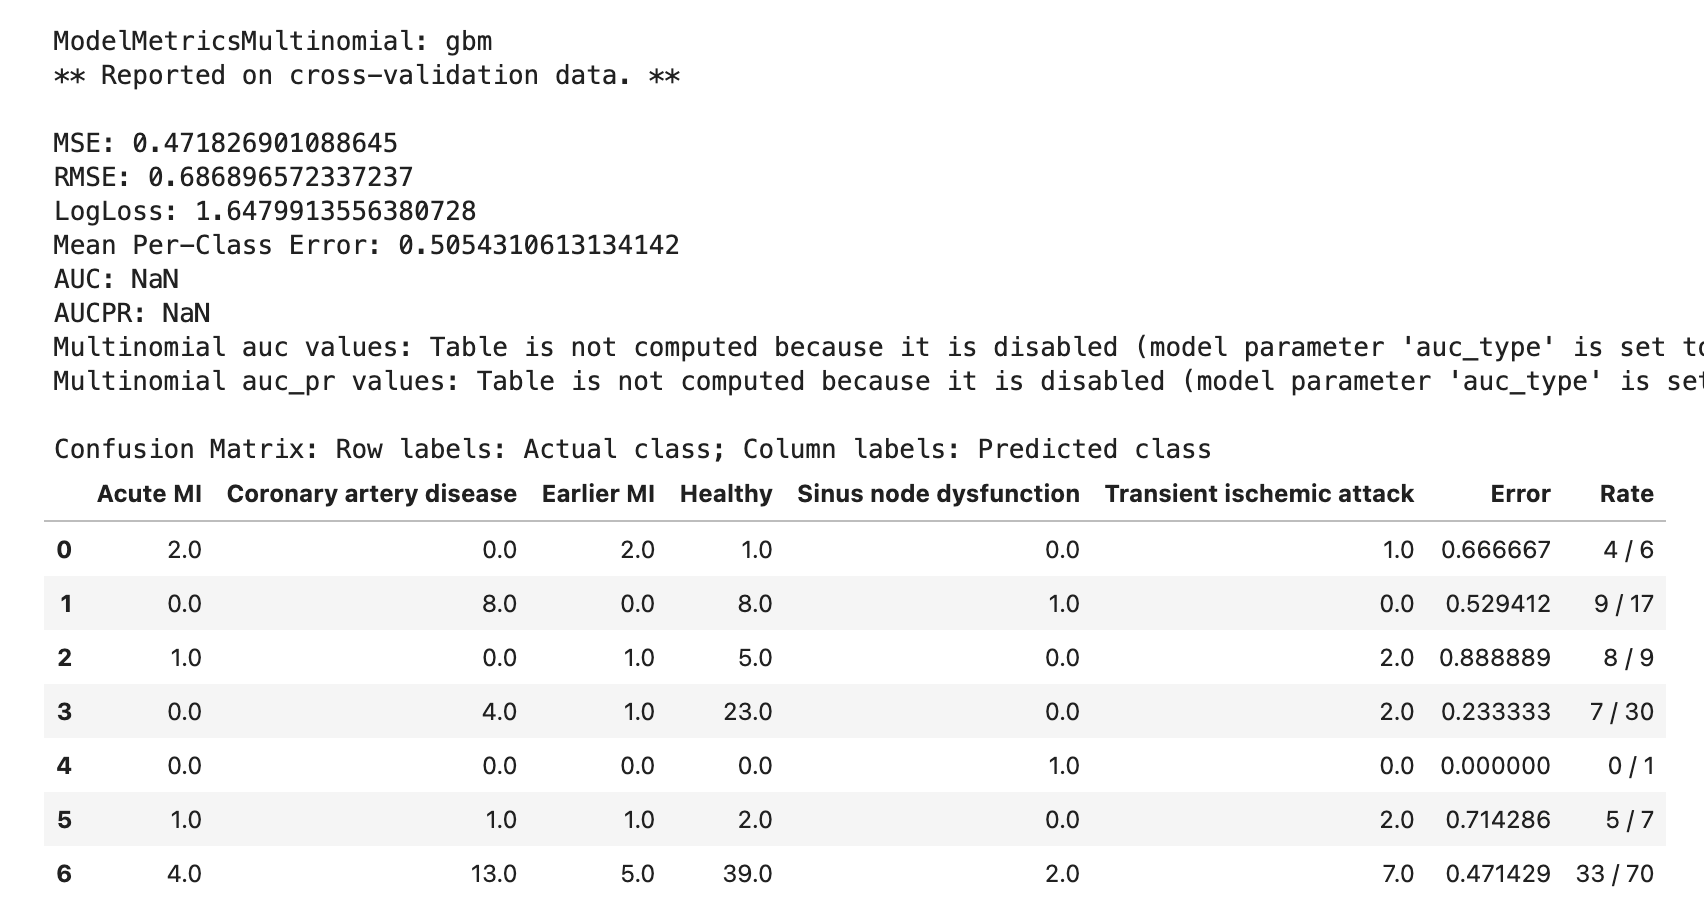

#### Let us now use Auto ML Deep learning to classify the output into 2 classes only instead of current 6 classes. This may give better results.

### Step 7 - Deep Learning - binary classification

In [37]:
import h2o
from h2o.automl import H2OAutoML

In [38]:
df = pd.read_csv('features_engineered.csv')

In [39]:
h2o.init(max_mem_size='8G', nthreads = 8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 24 mins
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_vikramkamthe_u6a1rb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.481 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [40]:
df_hf = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [41]:
#Making sure that y variable is treated as a factor
df_hf['diagnosis_binary'] = df_hf['diagnosis_binary'].asfactor()

In [42]:
#Drop the columns that we do not want to use in Model Building
ignored_column_list = ['comment_0','comment_1','comment_2','diagnosis','diagnosis_secondary','diagnosis_tertiary', 'diagnosis_primary', 'Patient ID']

In [43]:
df_hf = df_hf.drop(ignored_column_list)

In [44]:
aml = H2OAutoML(max_runtime_secs = 7200, seed = 1, nfolds=5, balance_classes=False, 
                class_sampling_factors=None, max_after_balance_size=5.0, max_runtime_secs_per_model=None, max_models=None, 
                stopping_metric='AUTO', stopping_tolerance=None, stopping_rounds=3, 
                #exclude_algos = None, 
                include_algos = ["DeepLearning", "XGBoost"], 
                #ignored_columns = ignored_column_list,
                exploitation_ratio=0, modeling_plan=None, preprocessing=None, monotone_constraints=None, 
                keep_cross_validation_predictions=False, keep_cross_validation_models=False, 
                keep_cross_validation_fold_assignment=False, sort_metric='AUTO')
aml.train(y='diagnosis_binary', training_frame = df_hf)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_2_20211126_135026_model_465


Status of Neuron Layers: predicting diagnosis_binary, 2-class classification, bernoulli distribution, CrossEntropy loss, 3,162 weights/biases, 60.9 KB, 119,000 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,155,Input,5.0,,,,,,,,,
1,,2,20,RectifierDropout,10.0,0.0,0.0,0.011616,0.07905,0.0,0.010901,0.11677,0.47513,0.059173
2,,3,2,Softmax,,0.0,0.0,0.001837,0.002162,0.0,0.022355,1.301918,0.000462,0.059633




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 7.381348182422466e-09
RMSE: 8.591477278339544e-05
LogLoss: 3.7706208970690986e-05
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9996199113999514: 


,,False,True,Error,Rate
0,False,30.0,0.0,0.0,(0.0/30.0)
1,True,0.0,40.0,0.0,(0.0/40.0)
2,Total,30.0,40.0,0.0,(0.0/70.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,9.996199e-01,1.000,33.0
1,max f2,9.996199e-01,1.000,33.0
2,max f0point5,9.996199e-01,1.000,33.0
3,max accuracy,9.996199e-01,1.000,33.0
4,max precision,1.000000e+00,1.000,0.0
5,max recall,9.996199e-01,1.000,33.0
6,max specificity,1.000000e+00,1.000,0.0
7,max absolute_mcc,9.996199e-01,1.000,33.0
8,max min_per_class_accuracy,9.996199e-01,1.000,33.0
9,max mean_per_class_accuracy,9.996199e-01,1.000,33.0



Gains/Lift Table: Avg response rate: 57.14 %, avg score: 57.14 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014286,1.000000e+00,1.75,1.750000,1.000000,1.000000e+00,1.000000,1.000000,0.025,0.025,75.0,75.000000,0.025000
1,2,0.028571,1.000000e+00,1.75,1.750000,1.000000,1.000000e+00,1.000000,1.000000,0.025,0.050,75.0,75.000000,0.050000
2,3,0.042857,1.000000e+00,1.75,1.750000,1.000000,1.000000e+00,1.000000,1.000000,0.025,0.075,75.0,75.000000,0.075000
3,4,0.042857,1.000000e+00,0.00,1.750000,0.000000,0.000000e+00,1.000000,1.000000,0.000,0.075,-100.0,75.000000,0.075000
4,5,0.057143,1.000000e+00,1.75,1.750000,1.000000,1.000000e+00,1.000000,1.000000,0.025,0.100,75.0,75.000000,0.100000
5,6,0.100000,9.999999e-01,1.75,1.750000,1.000000,9.999999e-01,1.000000,1.000000,0.075,0.175,75.0,75.000000,0.175000
6,7,0.157143,9.999996e-01,1.75,1.750000,1.000000,9.999998e-01,1.000000,1.000000,0.100,0.275,75.0,75.000000,0.275000
7,8,0.200000,9.999983e-01,1.75,1.750000,1.000000,9.999991e-01,1.000000,1.000000,0.075,0.350,75.0,75.000000,0.350000
8,9,0.300000,9.999923e-01,1.75,1.750000,1.000000,9.999967e-01,1.000000,0.999999,0.175,0.525,75.0,75.000000,0.525000
9,10,0.400000,9.999797e-01,1.75,1.750000,1.000000,9.999873e-01,1.000000,0.999996,0.175,0.700,75.0,75.000000,0.700000




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.22453275092998848
RMSE: 0.4738488692927192
LogLoss: 1.1982074696724343
Mean Per-Class Error: 0.18333333333333335
AUC: 0.8308333333333333
AUCPR: 0.8713392262685057
Gini: 0.6616666666666666

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04860366435983496: 


,,False,True,Error,Rate
0,False,25.0,5.0,0.1667,(5.0/30.0)
1,True,8.0,32.0,0.2,(8.0/40.0)
2,Total,33.0,37.0,0.1857,(13.0/70.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,4.860366e-02,0.831169,36.0
1,max f2,1.412551e-03,0.875576,56.0
2,max f0point5,4.860366e-02,0.851064,36.0
3,max accuracy,4.860366e-02,0.814286,36.0
4,max precision,1.000000e+00,1.000000,0.0
5,max recall,1.550808e-07,1.000000,68.0
6,max specificity,1.000000e+00,1.000000,0.0
7,max absolute_mcc,4.860366e-02,0.627863,36.0
8,max min_per_class_accuracy,4.860366e-02,0.800000,36.0
9,max mean_per_class_accuracy,4.860366e-02,0.816667,36.0



Gains/Lift Table: Avg response rate: 57.14 %, avg score: 38.70 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014286,9.999340e-01,1.7500,1.750000,1.000000,1.000000,1.000000,1.000000,0.025,0.025,75.00,75.000000,0.025000
1,2,0.028571,9.997687e-01,1.7500,1.750000,1.000000,0.999904,1.000000,0.999952,0.025,0.050,75.00,75.000000,0.050000
2,3,0.042857,9.995244e-01,1.7500,1.750000,1.000000,0.999547,1.000000,0.999817,0.025,0.075,75.00,75.000000,0.075000
3,4,0.042857,9.992966e-01,0.0000,1.750000,0.000000,0.000000,1.000000,0.999817,0.000,0.075,-100.00,75.000000,0.075000
4,5,0.057143,9.989054e-01,1.7500,1.750000,1.000000,0.999217,1.000000,0.999667,0.025,0.100,75.00,75.000000,0.100000
5,6,0.100000,9.960026e-01,1.7500,1.750000,1.000000,0.997684,1.000000,0.998817,0.075,0.175,75.00,75.000000,0.175000
6,7,0.157143,9.937857e-01,1.3125,1.590909,0.750000,0.994852,0.909091,0.997376,0.075,0.250,31.25,59.090909,0.216667
7,8,0.200000,9.554371e-01,1.7500,1.625000,1.000000,0.991001,0.928571,0.996010,0.075,0.325,75.00,62.500000,0.291667
8,9,0.300000,8.180254e-01,1.5000,1.583333,0.857143,0.931029,0.904762,0.974349,0.150,0.475,50.00,58.333333,0.408333
9,10,0.400000,3.998584e-01,1.5000,1.562500,0.857143,0.650224,0.892857,0.893318,0.150,0.625,50.00,56.250000,0.525000




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.828571,0.063888,0.857143,0.857143,0.857143,0.857143,0.714286
1,auc,0.861789,0.062347,0.937500,0.848485,0.897959,0.854167,0.770833
2,err,0.171429,0.063888,0.142857,0.142857,0.142857,0.142857,0.285714
3,err_count,2.400000,0.894427,2.000000,2.000000,2.000000,2.000000,4.000000
4,f0point5,0.842755,0.089024,0.789474,0.909091,0.925926,0.875000,0.714286
5,f1,0.854913,0.041306,0.857143,0.909091,0.833333,0.875000,0.800000
6,f2,0.877652,0.070682,0.937500,0.909091,0.757576,0.875000,0.909091
7,lift_top_group,1.821212,0.388977,2.333333,1.272727,2.000000,1.750000,1.750000
8,logloss,1.198208,0.459963,0.617529,1.743988,0.858345,1.498438,1.272738
9,max_per_class_error,0.340476,0.192254,0.250000,0.333333,0.285714,0.166667,0.666667



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-11-26 14:44:15,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-11-26 14:44:15,53 min 39.628 sec,63636 obs/sec,10.0,1,700.0,0.473333,1.163992,0.085153,0.808333,0.879005,1.75,0.242857
2,,2021-11-26 14:44:17,53 min 41.084 sec,82295 obs/sec,1700.0,170,119000.0,0.000086,0.000038,1.000000,1.000000,1.000000,1.75,0.000000



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,no_of_+_beats,1.000000,1.000000,0.010976
1,HRV_LFHF,0.966417,0.966417,0.010608
2,paroxysmalsupraventriculartachycardiawithaberratedQRS,0.874221,0.874221,0.009596
3,SVEBswithwideQRS,0.867770,0.867770,0.009525
4,percentage_of_j_beats,0.839156,0.839156,0.009211
5,AVnodalblock2degreeMoebits1,0.825715,0.825715,0.009063
6,PVCsonbradycardia,0.820570,0.820570,0.009007
7,PVCsonsinusarrhythmia,0.807680,0.807680,0.008865
8,HRV_DFA_alpha1_DimMean,0.803463,0.803463,0.008819
9,WPW,0.799493,0.799493,0.008776



See the whole table with table.as_data_frame()


#### The above results show that Deep Learning Model doing pretty well for binary classification on cross validation data - only 13 / 70 are mis-classified overall.

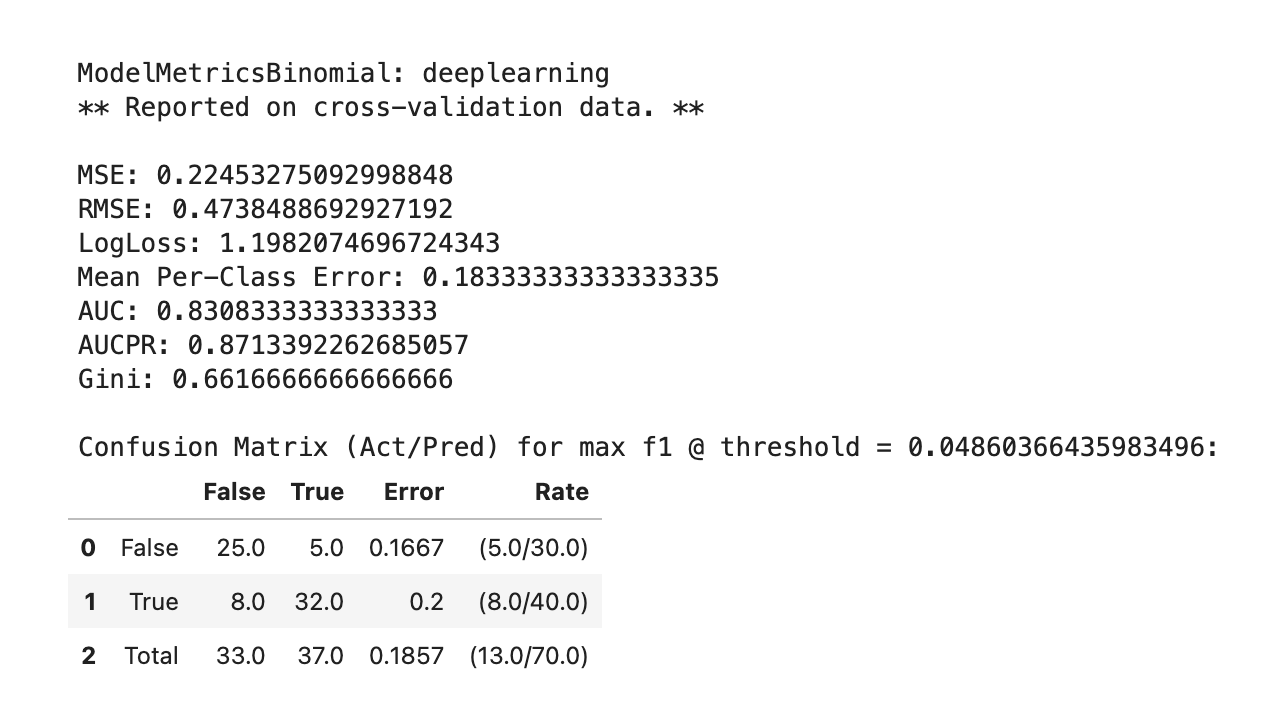

### *** The end ***